# Spiker 

In [1]:
# Set the path
import sys
sys.path.append("/Users/vladimiromelyusik/ACT")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.act_types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
from act.data_processing import ACTDataProcessor as dp
from act.act_module import ACTModule, ACTModuleParameters

import numpy as np
import matplotlib.pyplot as plt

1. Generate target traces to tune to (as if they were provided by the user).

In [7]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [8]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_orig", 
        sim_idx = sim_idx, 
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)])

    simulator.submit_job(target_cell, sim_params)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [9]:
simulator.run_jobs(3)

In [10]:
# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_orig")

output/spiker_orig


In [2]:
# Plot the traces and the FI curve
simulated_data = np.load("output/spiker_orig/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

Text(0, 0.5, 'Voltage (mV)')

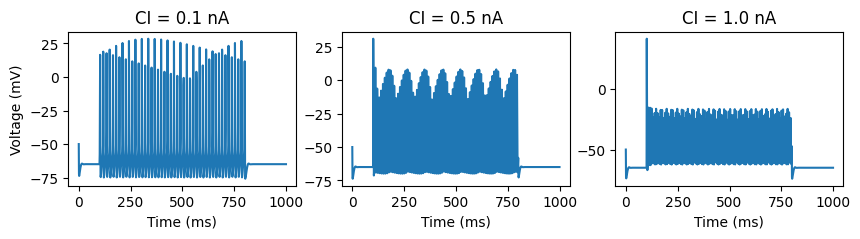

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (10, 2))
for axid, amp in enumerate([0.1, 0.5, 1.0]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

In [ ]:
frequencies = dp.get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

Text(0.5, 1.0, 'FI Curve')

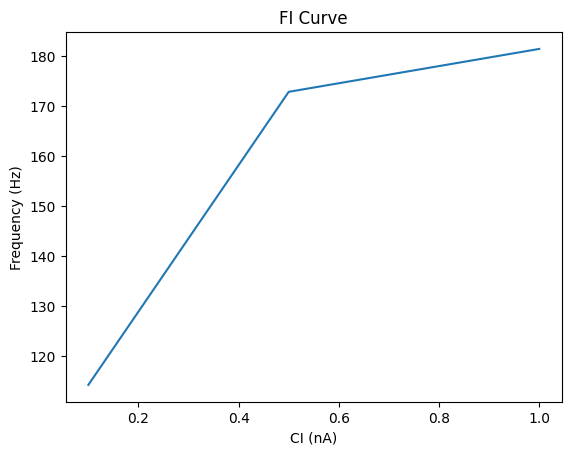

In [13]:
plt.plot([0.1, 0.5, 1.0], frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

2. Assume passive properties are optimized offline (see the notebook on PP tuning). Optimize active channels.

In [7]:
random_state = np.random.RandomState(123)

In [8]:
# Parameter ranges as if provided by the user
gbar_na = 0.12
gbar_kdr = 0.036

gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Na: (0.0782118488641283, 0.13716836009702277)
Kdr: (0.031916673835844345, 0.04592366584349204)


In [9]:
# Define the train cell
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [10]:
sim_params = SimulationParameters(
    sim_name = "spiker_orig_train",
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0)])

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    train_features = 
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
    prediction_eval_method = 'fi_curve',
    spike_threshold = 0,
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    ),
    first_n_spikes = 20,
    random_state = 123,
    save_file = f"output/final/results/saved_metrics.json"
)

original_module = ACTModule(
    ACTModuleParameters(
        module_folder_name = "output/final",
        cell = train_cell,
        target_traces_file = f"output/spiker_orig/combined_out.npy",
        sim_params = sim_params,
        optim_params = optim_params
    )
)

In [ ]:
predicted_g_data_file = original_module.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA

        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/output/final/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Num Troughs', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough

'/Users/vladimiromelyusik/ACT/experiments/Spiker/output/final/prediction_eval1/combined_out.npy'

In [ ]:
original_module.pickle_rf(original_module.rf_model,f"output/final/trained_rf.pkl")

# Results and Metrics

In [11]:
final_folder = "output/final"

from act import ACTPlot
ACTPlot.plot_v_comparison(
    final_folder,
    '/Users/vladimiromelyusik/ACT/experiments/Spiker/output/final/prediction_eval1/combined_out.npy', 
    sim_params.CI,
    sim_params.h_dt
    )

ACTPlot.plot_fi_comparison(
    final_folder, 
    sim_params.CI
    )

In [ ]:
from act.Metrics import Metrics


metrics = Metrics()

mean, stdev = metrics.save_interspike_interval_comparison(
    final_folder,
    predicted_g_data_file,
    sim_params.CI, 
    sim_params.h_dt,
    first_n_spikes=5,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

'''
"gnabar_hh_orig" = 0.12
"gkbar_hh_orig"=0.036
"gl_hh_orig"=0.0003
'''

actual_g={"gnabar_hh_spiker": 0.12,"gkbar_hh_spiker": 0.036}

    
metrics.save_prediction_g_mae(
    actual_g=actual_g,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

metrics.save_feature_mae(
    final_folder,
    predicted_g_data_file,
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats", "lto-hto_amplitude", "lto-hto_frequency"],
    sim_params.h_dt,
    first_n_spikes=5,
    CI_settings=sim_params.CI,
    save_file=f"{final_folder}/results/saved_metrics.json"
)


Interspike times (Target): [[1.58e+01 1.55e+01 1.55e+01 1.55e+01]
 [9.90e+00 9.20e+00 9.10e+00 9.10e+00]
 [1.00e+06 1.00e+06 1.00e+06 1.00e+06]]
Interspike times (Prediction): [[1.59e+01 1.56e+01 1.55e+01 1.56e+01]
 [1.00e+01 9.30e+00 9.20e+00 9.30e+00]
 [1.00e+06 1.00e+06 1.00e+06 1.00e+06]]
MAE for each I injection: [0.07499999999999574, 0.125, 0.0]
Mean interspike-interval MAE: 0.06666666666666525
Standard Deviation interspike-interval MAE: 0.05137011669140791
MAE of final g prediction: 0.006162652992382021
MAE of summary features for final prediction: 0.26447636659848633
